## REGRESSÃO NÃO LINEAR MÚLTIPLA
Exemplo 5

In [55]:
# Importação dos pacotes
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.io as pio
pio.renderers.default = 'notebook'

from scipy.stats import pearsonr # correlações de Pearson
from scipy.optimize import curve_fit
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos

import pingouin as pg # outro modo para obtenção de matrizes de correlações

from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal

import networkx as nx
import matplotlib.cm as cm

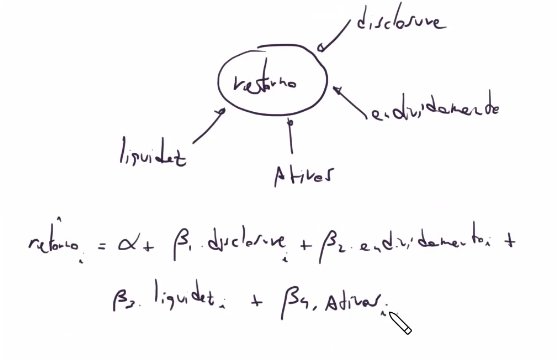

In [56]:
df_empresas = pd.read_csv('/home/usp_ds_analytics/regression_analysis/data/empresas.csv', delimiter=',')
df_empresas.head()

,empresa,retorno,disclosure,endividamento,ativos,liquidez
0,Adidas,63.67,83,1.3,3967,14.3
1,BASF,55.49,91,33.9,5450,16.8
2,Bayer,52.42,77,36.1,4327,15.5
3,BSH,54.00,90,20.8,4109,16.8
4,Bosch,68.01,93,14.1,4458,17.0


In [57]:
df_empresas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   empresa        124 non-null    object 
 1   retorno        124 non-null    float64
 2   disclosure     124 non-null    int64  
 3   endividamento  124 non-null    float64
 4   ativos         124 non-null    int64  
 5   liquidez       124 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 5.9+ KB


Como todas as variáveis de interesse são quantitativas, não precisamos aplicar dummy

In [58]:
df_empresas.describe()

,retorno,disclosure,endividamento,ativos,liquidez
count,124.000000,124.000000,124.000000,124.000000,124.000000
mean,46.195484,49.677419,27.734677,3739.064516,12.300000
std,15.075886,31.338059,12.454287,1538.500462,3.141746
min,21.030000,6.000000,1.200000,1851.000000,7.900000
25%,33.840000,18.000000,18.525000,2597.000000,9.300000
50%,44.175000,41.000000,24.950000,3476.000000,12.200000
75%,58.205000,83.000000,34.125000,4458.000000,15.800000
max,86.180000,98.000000,64.900000,9010.000000,17.000000


### Matriz de Correlação

In [59]:
correlation_matrix = df_empresas.iloc[:, 1:6].corr()
correlation_matrix

,retorno,disclosure,endividamento,ativos,liquidez
retorno,1.000000,0.863747,0.004577,0.811349,0.859083
disclosure,0.863747,1.000000,0.136587,0.831343,0.867605
endividamento,0.004577,0.136587,1.000000,0.228085,-0.081803
ativos,0.811349,0.831343,0.228085,1.000000,0.702286
liquidez,0.859083,0.867605,-0.081803,0.702286,1.000000


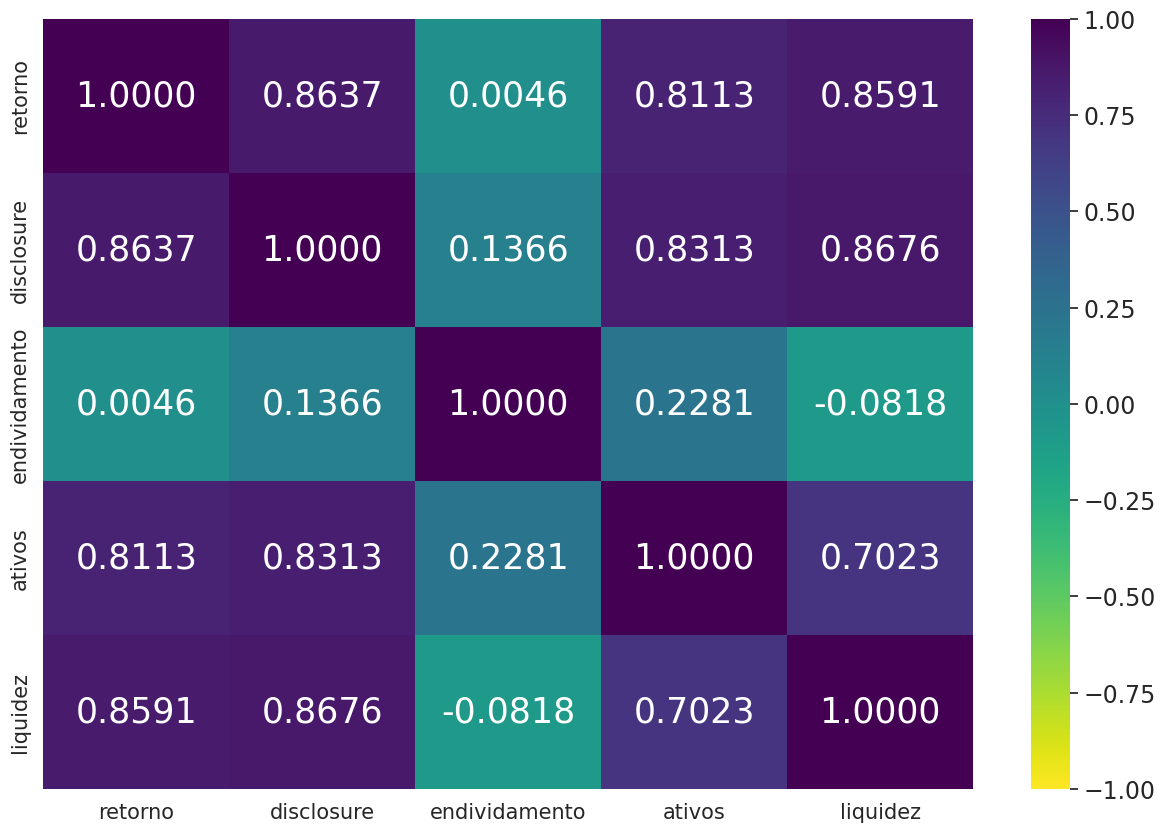

In [60]:
# Mapa de calor com as correlações entre todas as variáveis quantitativas
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.4f',
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 25}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=15)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=15)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()


Será que endividamente ficará no modelo final?

É importante avaliar o comportamento de acordo com a presença de uma ou mais variável preditora.

In [61]:
# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
correlation_matrix2 = pg.rcorr(df_empresas, method='pearson',
                              upper='pval', decimals=4,
                              pval_stars={0.01: '***',
                                          0.05: '**',
                                          0.10: '*'})

correlation_matrix2

/root/.local/share/virtualenvs/usp_ds_analytics-M2oHMey2/lib/python3.11/site-packages/pingouin/correlation.py:1116: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,retorno,disclosure,endividamento,ativos,liquidez
retorno,-,***,,***,***
disclosure,0.8637,-,,***,***
endividamento,0.0046,0.1366,-,**,
ativos,0.8113,0.8313,0.2281,-,***
liquidez,0.8591,0.8676,-0.0818,0.7023,-


### Diagrama interessante (grafo) que mostra a inter-relação entre as variáveis e a magnitude das correlações entre elas

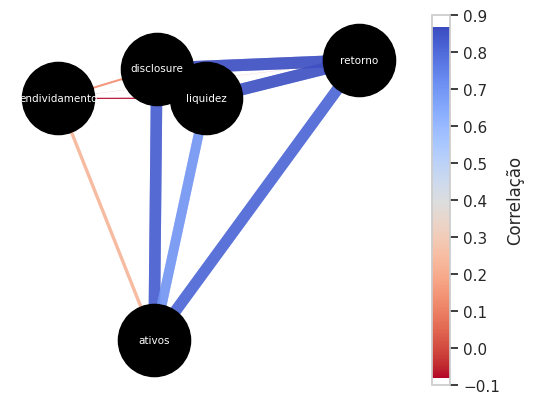

In [62]:
# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in correlation_matrix.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(correlation_matrix.columns):
    for j, variable2 in enumerate(correlation_matrix.columns):
        if i != j:
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('coolwarm_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Ajuste das posições dos nós das variáveis
pos["retorno"] = (pos["retorno"][0] + 1.8, pos["retorno"][1] + 1.8)
pos["disclosure"] = (pos["disclosure"][0], pos["disclosure"][1] + 1.8)
pos["endividamento"] = (pos["endividamento"][0], pos["endividamento"][1] + 1.8)
pos["ativos"] = (pos["ativos"][0], pos["ativos"][1])
pos["liquidez"] = (pos["liquidez"][0], pos["liquidez"][1] + 1.8)

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.7)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations),0) - 0.1,
                         max(correlations) + 0.1, 0.1))

# Exibição do gráfico
plt.show()

- Ativos, liquidez e disclosure tem alta correlação com retorno.
- Porém elas tem uma alta correlação entre elas também.

### Distribuições das variáveis, scatters, valores das correlações e suas respectivas significâncias

<Figure size 2000x1000 with 0 Axes>

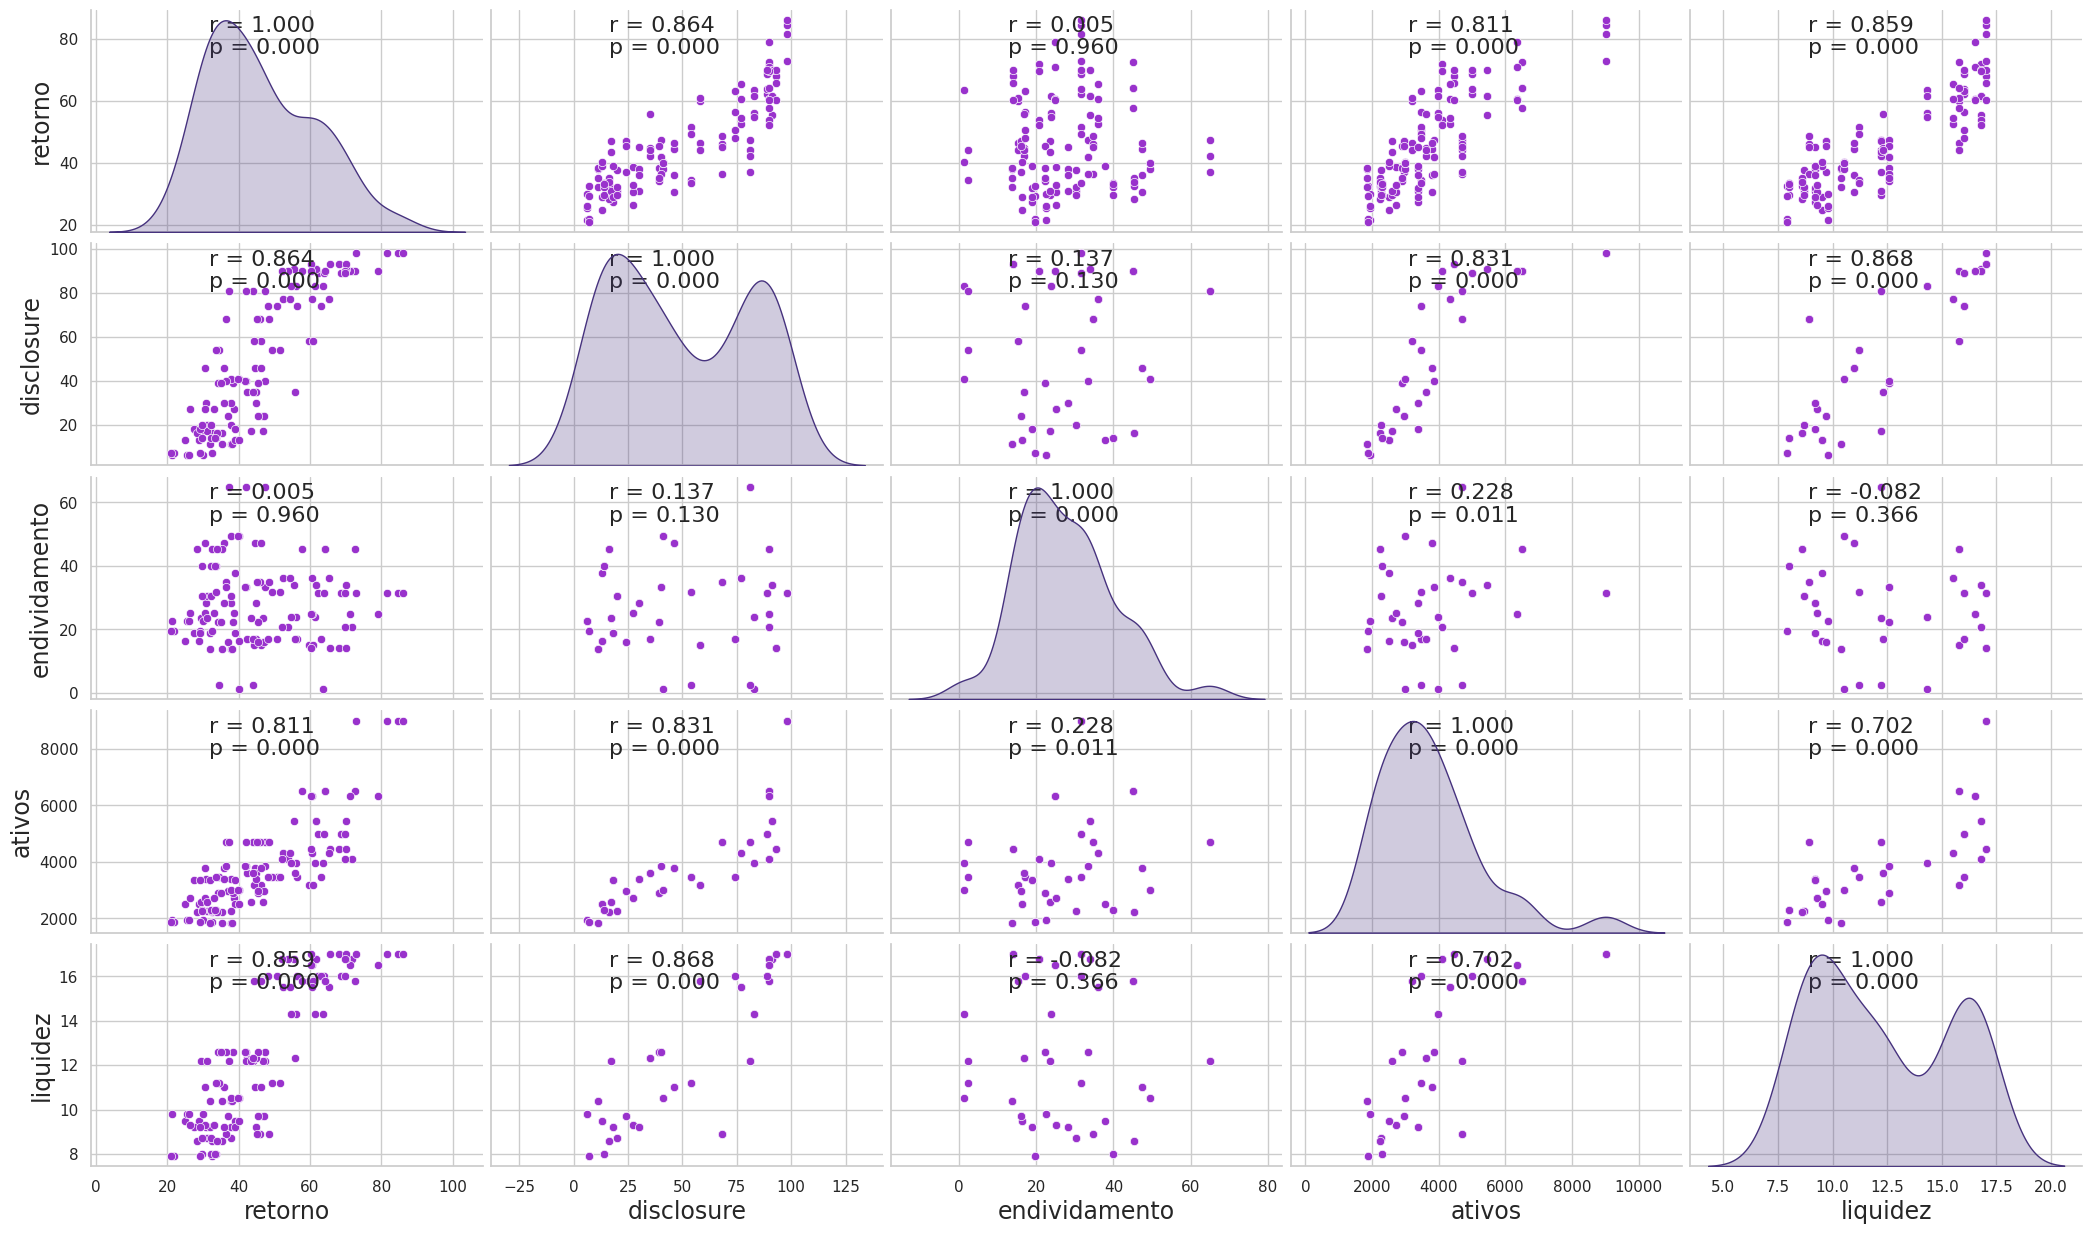

In [63]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.30, .9), xycoords=ax.transAxes, fontsize=16)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.30, .8), xycoords=ax.transAxes, fontsize=16)

# Configuração do gráfico
sns.set_theme(style="whitegrid", palette="viridis")

plt.figure(figsize=(20,10))
graph = sns.pairplot(df_empresas, diag_kind="kde",
                     plot_kws={"color": "darkorchid"},
                     height=2.5, aspect=1.7)
graph.map(corrfunc)
for ax in graph.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=17)
    ax.set_ylabel(ax.get_ylabel(), fontsize=17)
plt.show()

### Estimando o Modelo de Regressão Múltipla

In [64]:
modelo_empresas = sm.OLS.from_formula('retorno ~ disclosure +\
                                      endividamento + ativos +\
                                          liquidez', df_empresas).fit()

# Parâmetros do 'modelo_empresas'
modelo_empresas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                retorno   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     147.9
Date:                Sat, 17 Aug 2024   Prob (F-statistic):           3.35e-45
Time:                        11:33:30   Log-Likelihood:                -401.07
No. Observations:                 124   AIC:                             812.1
Df Residuals:                     119   BIC:                             826.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.0506      4.080      1.483      0.141      -2.028      14.129
disclosure        0.1067      0.048      2.227      0.028       0.012       0.202
endividamento    -0.0882      0.051     -1.723      0.087      -0.190       0.013
ativos            0.0035      0.001      5.134      0.000       0.002       0.005
liquidez          1.9762      0.396      4.987      0.000       1.191       2.761
==============================================================================
Omnibus:                       35.509   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.127
Skew:                          -0.136   Prob(JB):                       0.0283
Kurtosis:                       1.858   Cond. No.                     2.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- R-squared:	0.833 - modelo bonitão!
- Prob (F-statistic):	3.35e-45 - pelo menos um beta estatisticamente diferente de zero
- não olha o p-valeu de alfa
- somento o p-value do 'endividamento' não passou

Note que o parâmetro da variável 'endividamento' não é estatisticamente
#significante ao nível de significância de 5% (nível de confiança de 95%).

### Modelo apenas com endividamento
Será que ele sozinho passa?

In [65]:
modelo_auxiliar1 = sm.OLS.from_formula('retorno ~ endividamento',
                                       df_empresas).fit()

modelo_auxiliar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                retorno   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                  0.002556
Date:                Sat, 17 Aug 2024   Prob (F-statistic):              0.960
Time:                        11:33:30   Log-Likelihood:                -511.87
No. Observations:                 124   AIC:                             1028.
Df Residuals:                     122   BIC:                             1033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        46.0418      3.330     13.828      0.000      39.450      52.633
endividamento     0.0055      0.110      0.051      0.960      -0.211       0.222
==============================================================================
Omnibus:                        8.297   Durbin-Watson:                   0.594
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.084
Skew:                           0.573   Prob(JB):                       0.0176
Kurtosis:                       2.496   Cond. No.                         74.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1a razão para uma variável cair no modelo multivariável:
- Ela sozinha não ser estatisticamente significante, ou diferente de zero.
- Ela sozinha então não explica o comportamento do modelo.

### Modelo sem endividamento

In [66]:
modelo_auxiliar2 = sm.OLS.from_formula('retorno ~ disclosure + ativos +\
                                       liquidez',
                                       df_empresas).fit()

modelo_auxiliar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                retorno   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     193.1
Date:                Sat, 17 Aug 2024   Prob (F-statistic):           9.55e-46
Time:                        11:33:30   Log-Likelihood:                -402.60
No. Observations:                 124   AIC:                             813.2
Df Residuals:                     120   BIC:                             824.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0461      3.380      0.605      0.546      -4.647       8.739
disclosure     0.0874      0.047      1.861      0.065      -0.006       0.180
ativos         0.0032      0.001      4.850      0.000       0.002       0.005
liquidez       2.2507      0.366      6.152      0.000       1.526       2.975
==============================================================================
Omnibus:                       18.497   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.349
Skew:                          -0.103   Prob(JB):                       0.0689
Kurtosis:                       2.003   Cond. No.                     2.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ops, agora o disclosure não passa? Ele mostrou p-value de 0.065

2a razão para uma variável cair:
- alta correlação dela com outra variável preditora
- aí tem o problema de multiconilariedade

### Modelo sem o disclosure

In [67]:
modelo_auxiliar3 = sm.OLS.from_formula('retorno ~ ativos +\
                                       liquidez',
                                       df_empresas).fit()

modelo_auxiliar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                retorno   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     282.1
Date:                Sat, 17 Aug 2024   Prob (F-statistic):           2.76e-46
Time:                        11:33:30   Log-Likelihood:                -404.37
No. Observations:                 124   AIC:                             814.7
Df Residuals:                     121   BIC:                             823.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5348      2.341     -1.083      0.281      -7.169       2.100
ativos         0.0040      0.001      7.649      0.000       0.003       0.005
liquidez       2.7391      0.258     10.637      0.000       2.229       3.249
==============================================================================
Omnibus:                       23.591   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.887
Skew:                          -0.087   Prob(JB):                       0.0527
Kurtosis:                       1.947   Cond. No.                     1.65e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Opa, agora temos um *modelo final linear*!

### Modelo apenas com disclosure

In [68]:
modelo_auxiliar4 = sm.OLS.from_formula('retorno ~ disclosure',
                                       df_empresas).fit()

modelo_auxiliar4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                retorno   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     358.4
Date:                Sat, 17 Aug 2024   Prob (F-statistic):           4.06e-38
Time:                        11:33:30   Log-Likelihood:                -426.89
No. Observations:                 124   AIC:                             857.8
Df Residuals:                     122   BIC:                             863.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.5533      1.288     19.845      0.000      23.004      28.102
disclosure     0.4155      0.022     18.932      0.000       0.372       0.459
==============================================================================
Omnibus:                        0.701   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.315
Skew:                           0.007   Prob(JB):                        0.854
Kurtosis:                       3.246   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- O disclosure sozinho passa. Ele é uma boa preditora para o comportamento do 'retorno'
- Não avalie de maneira univariada um modelo multivariado

### Procedimento Stepwise

In [69]:
# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

O stepwise não tem capacidade de tirar o alfa. Esse só tira os betas

In [70]:
# Estimação do modelo por meio do procedimento Stepwise
modelo_step_empresas = stepwise(modelo_empresas, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 retorno ~ Q('disclosure') + Q('endividamento') + Q('ativos') + Q('liquidez')

 Discarding atribute "Q('endividamento')" with p-value equal to 0.08749071283026176 

Estimating model...: 
 retorno ~ Q('disclosure') + Q('ativos') + Q('liquidez')

 Discarding atribute "Q('disclosure')" with p-value equal to 0.06514029954310709 

Estimating model...: 
 retorno ~ Q('ativos') + Q('liquidez')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('endividamento')", 'p-value': np.float64(0.08749071283026176)}
{'atribute': "Q('disclosure')", 'p-value': np.float64(0.06514029954310709)}

 Model after stepwise process...: 
 retorno ~ Q('ativos') + Q('liquidez') 

                            OLS Regression Results                            
Dep. Variable:                retorno   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Meth

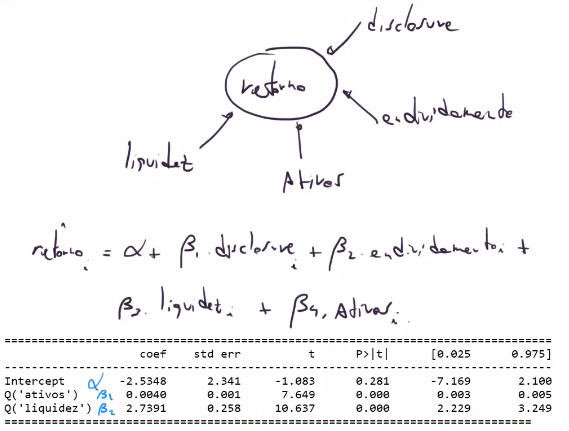

### Teste de verificação da aderência dos resíduos à normalidade

Teste de Shapiro-Wilk (n < 30)
- from scipy.stats import shapiro
- shapiro(modelo_step_empresas.resid)

Teste de Shapiro-Francia (n >= 30)
- Carregamento da função 'shapiro_francia' do pacote 'statstests.tests'
- Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
- https://stats-tests.github.io/statstests/

#### Shapiro Francia

In [71]:
# Teste de Shapiro-Francia: interpretação
teste_sf = shapiro_francia(modelo_step_empresas.resid) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9738705318499362
statistics z  :  2.0934256948868866
p-value  :  0.01815558534418546
Statistics W=0.97387, p-value=0.018156
Rejeita-se H0 - Distribuição não aderente à normalidade


Plotando os resíduos do 'modelo_step_empresas' e acrescentando uma curva normal teórica para comparação entre as distribuições

Kernel density estimation (KDE) - forma não-paramétrica para estimação da
função densidade de probabilidade de determinada variável

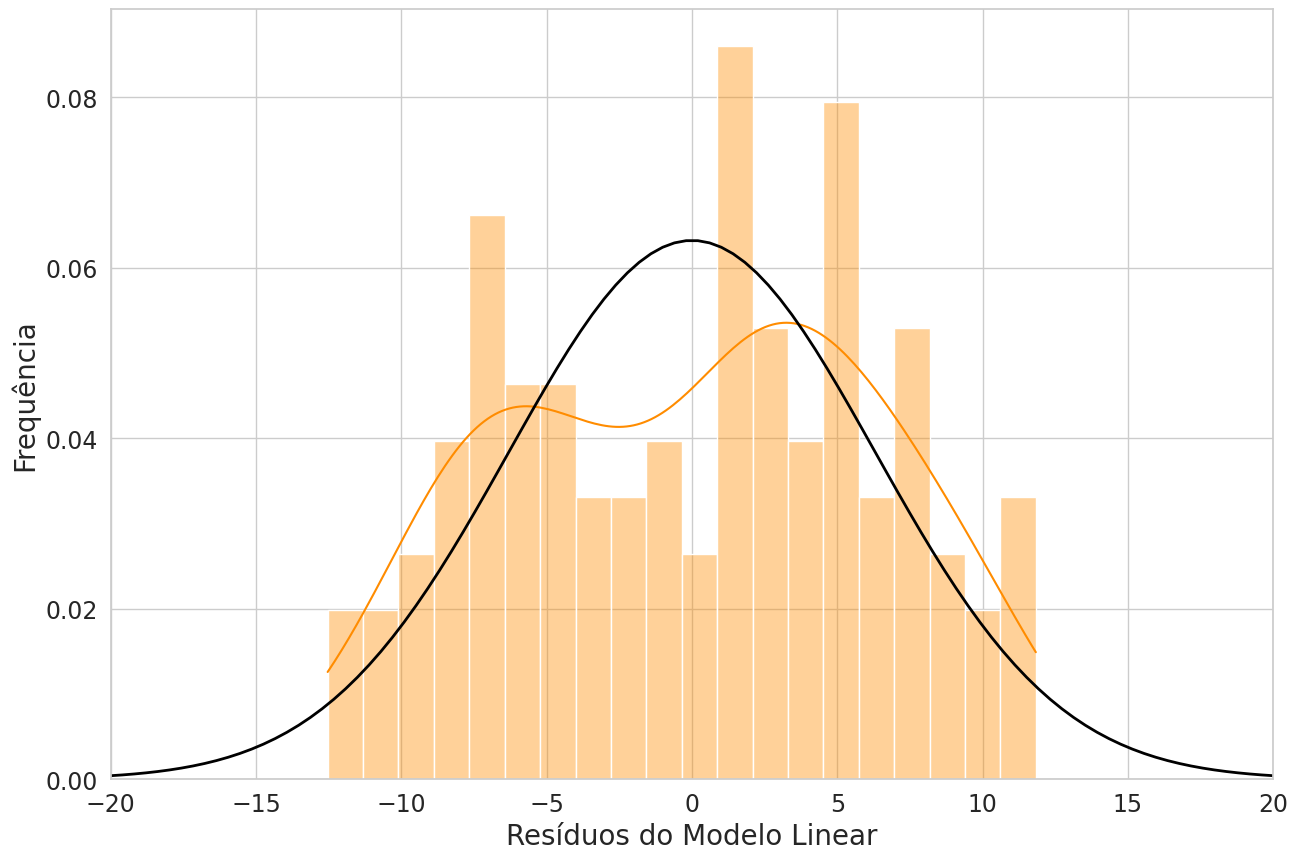

In [72]:
# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_step_empresas.resid)

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_step_empresas.resid, bins=20, kde=True, stat="density",
             color='darkorange', alpha=0.4)
plt.xlim(-20, 20)
x = np.linspace(-20, 20, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Linear', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

### Transformação de Box-Cox

In [73]:
# 'yast' é uma variável que traz os valores transformados (Y*)
# 'lmbda' é o lambda de Box-Cox
yast, lmbda = boxcox(df_empresas['retorno'])

print("Lambda: ",lmbda)

Lambda:  -0.022564139156469726


In [74]:
## Inserindo o lambda de Box-Cox no dataset para a estimação de um novo modelo
df_empresas['bc_retorno'] = yast
df_empresas.head()

,empresa,retorno,disclosure,endividamento,ativos,liquidez,bc_retorno
0,Adidas,63.67,83,1.3,3967,14.3,3.965002
1,BASF,55.49,91,33.9,5450,16.8,3.839599
2,Bayer,52.42,77,36.1,4327,15.5,3.787582
3,BSH,54.00,90,20.8,4109,16.8,3.814731
4,Bosch,68.01,93,14.1,4458,17.0,4.024999


In [75]:
# Verificação do cálculo, apenas para fins didáticos
df_empresas['bc_retorno2'] = ((df_empresas['retorno'])**(lmbda) - 1) / (lmbda)
df_empresas.head(10)

,empresa,retorno,disclosure,endividamento,ativos,liquidez,bc_retorno,bc_retorno2
0,Adidas,63.67,83,1.3,3967,14.3,3.965002,3.965002
1,BASF,55.49,91,33.9,5450,16.8,3.839599,3.839599
2,Bayer,52.42,77,36.1,4327,15.5,3.787582,3.787582
3,BSH,54.00,90,20.8,4109,16.8,3.814731,3.814731
4,Bosch,68.01,93,14.1,4458,17.0,4.024999,4.024999
5,Daimler AG,64.13,90,45.2,6498,15.8,3.971556,3.971556
6,Deutsche Bank,68.76,89,31.6,4993,16.0,4.034969,4.034969
7,Faber-Castell,79.02,90,24.9,6352,16.5,4.161187,4.161187
8,Group Technologies,84.64,98,31.5,9010,17.0,4.223394,4.223394
9,Lufthansa,59.84,58,15.2,3189,15.8,3.908473,3.908473


In [76]:
del df_empresas['bc_retorno2']

#### Estimando um novo modelo múltiplo com variável dependente transformada por Box-Cox

In [77]:
modelo_bc = sm.OLS.from_formula('bc_retorno ~ disclosure +\
                                endividamento + ativos +\
                                    liquidez', df_empresas).fit()

# Parâmetros do 'modelo_bc'
modelo_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bc_retorno   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     119.9
Date:                Sat, 17 Aug 2024   Prob (F-statistic):           8.80e-41
Time:                        11:33:30   Log-Likelihood:                 74.551
No. Observations:                 124   AIC:                            -139.1
Df Residuals:                     119   BIC:                            -125.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.8844      0.088     32.752      0.000       2.710       3.059
disclosure        0.0034      0.001      3.291      0.001       0.001       0.005
endividamento    -0.0013      0.001     -1.133      0.260      -0.003       0.001
ativos         4.331e-05   1.46e-05      2.967      0.004    1.44e-05    7.22e-05
liquidez          0.0359      0.009      4.202      0.000       0.019       0.053
==============================================================================
Omnibus:                        3.781   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.267
Skew:                          -0.303   Prob(JB):                        0.195
Kurtosis:                       2.486   Cond. No.                     2.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Endividamente não passou mesmo hein. Mas esse ainda não é o modelo final. Vamos aplicar o stepwise.

### Aplicando o procedimento Stepwise no 'modelo_bc"

In [78]:
modelo_step_empresas_bc = stepwise(modelo_bc, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 bc_retorno ~ Q('disclosure') + Q('endividamento') + Q('ativos') + Q('liquidez')

 Discarding atribute "Q('endividamento')" with p-value equal to 0.2596629271283634 

Estimating model...: 
 bc_retorno ~ Q('disclosure') + Q('ativos') + Q('liquidez')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('endividamento')", 'p-value': np.float64(0.2596629271283634)}

 Model after stepwise process...: 
 bc_retorno ~ Q('disclosure') + Q('ativos') + Q('liquidez') 

                            OLS Regression Results                            
Dep. Variable:             bc_retorno   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     159.0
Date:                Sat, 17 Aug 2024   Prob (F-statistic):           1.21e-41
Time:                        11:33:30   Lo

Note que a variável 'disclosure' retorna ao modelo na forma funcional
não linear!

3a razão para excluir uma variável do modelo multivariado:
- uso incorreto da forma funcional. As vezes parece linear, mas não é linear

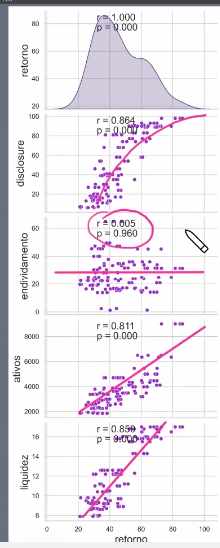

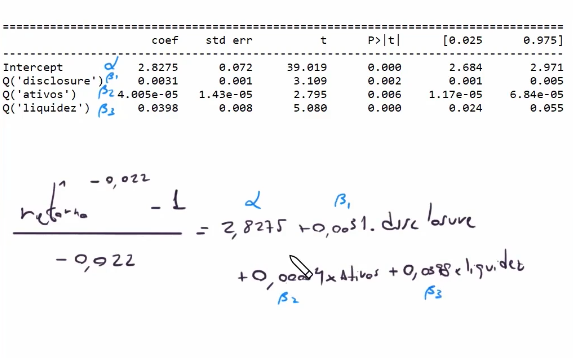

#### Verificando a normalidade dos resíduos do 'modelo_step_empresas_bc'

In [79]:
# Teste de Shapiro-Francia: interpretação
teste_sf = shapiro_francia(modelo_step_empresas_bc.resid) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9870486148410434
statistics z  :  0.6866622027236406
p-value  :  0.24614781033076372
Statistics W=0.98705, p-value=0.246148
Não se rejeita H0 - Distribuição aderente à normalidade


#### Plotando os novos resíduos do 'modelo_step_empresas_bc' e acrescentando uma curva normal teórica para comparação entre as distribuições

In [80]:
# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_step_empresas_bc.resid)

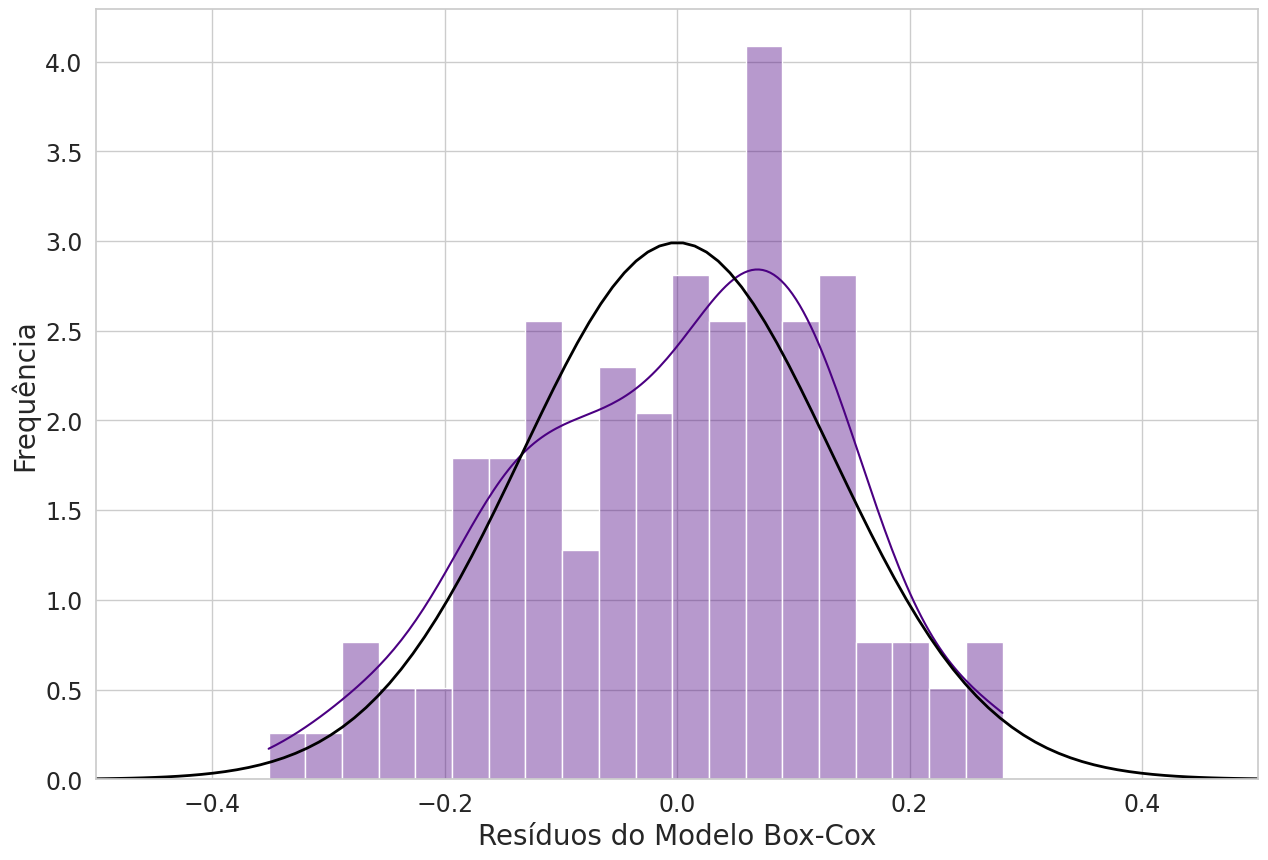

In [81]:
# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_step_empresas_bc.resid, bins=20, kde=True, stat="density",
             color='indigo', alpha=0.4)
plt.xlim(-0.5, 0.5)
x = np.linspace(-0.5, 0.5, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Box-Cox', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

### Resumo dos dois modelos obtidos pelo procedimento Stepwise (linear e com Box-Cox)

In [82]:
summary_col([modelo_step_empresas, modelo_step_empresas_bc],
            model_names=["STEPWISE","STEPWISE BOX-COX"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs))
        })

,STEPWISE,STEPWISE BOX-COX
Intercept,-2.5348,2.8275***
,(2.3409),(0.0725)
Q('ativos'),0.0040***,0.0000***
,(0.0005),(0.0000)
Q('liquidez'),2.7391***,0.0398***
,(0.2575),(0.0078)
Q('disclosure'),,0.0031***
,,(0.0010)
R-squared,0.8234,0.7990
R-squared Adj.,0.8205,0.7940


>[!warning] CUIDADO!!! OS PARÂMETROS NÃO SÃO DIRETAMENTE COMPARÁVEIS!


### Fazendo predições com o 'modelo_step_empresas_bc'
Qual é o valor do retorno, em média, para 'disclosure' igual a 50,
'liquidez' igual a 14 e 'ativos' igual a 4000, ceteris paribus?


In [83]:
modelo_step_empresas_bc.predict(pd.DataFrame({'const':[1],
                                              'disclosure':[50],
                                              'ativos':[4000],
                                              'liquidez':[14]}))

0    3.702015
dtype: float64

Não podemos nos esquecer de fazer o cálculo para a obtenção do
#fitted value de Y (variável 'retorno')

In [84]:
(3.702016 * lmbda + 1) ** (1 / lmbda)

np.float64(47.742626897838946)

In [85]:
# Salvando os fitted values de 'modelo_step_empresas' e
#'modelo_step_empresas_bc'

df_empresas['yhat_step_empresas'] = modelo_step_empresas.fittedvalues
df_empresas['yhat_step_empresas_bc'] = (modelo_step_empresas_bc.fittedvalues
                                        * lmbda + 1) ** (1 / lmbda)

In [86]:
# Visualizando os dois fitted values dos modelos 'modelo_step_empresas' e
#'modelo_step_empresas_bc' no dataset
df_empresas[['empresa','retorno','yhat_step_empresas','yhat_step_empresas_bc']]

,empresa,retorno,yhat_step_empresas,yhat_step_empresas_bc
0,Adidas,63.67,52.590460,54.072393
1,BASF,55.49,65.403203,66.165319
2,Bayer,52.42,57.325376,56.706216
3,BSH,54.00,60.009319,62.161048
4,Bosch,68.01,61.960912,64.337230
...,...,...,...,...
119,DuPont,39.85,38.276327,38.078000
120,ExxonMobil,44.16,45.724617,41.446025
121,FedEx,45.38,35.988530,34.685312
122,Ford Motors,45.25,40.711577,41.929545


### Ajustes dos modelos: valores previstos (fitted values) X valores reais

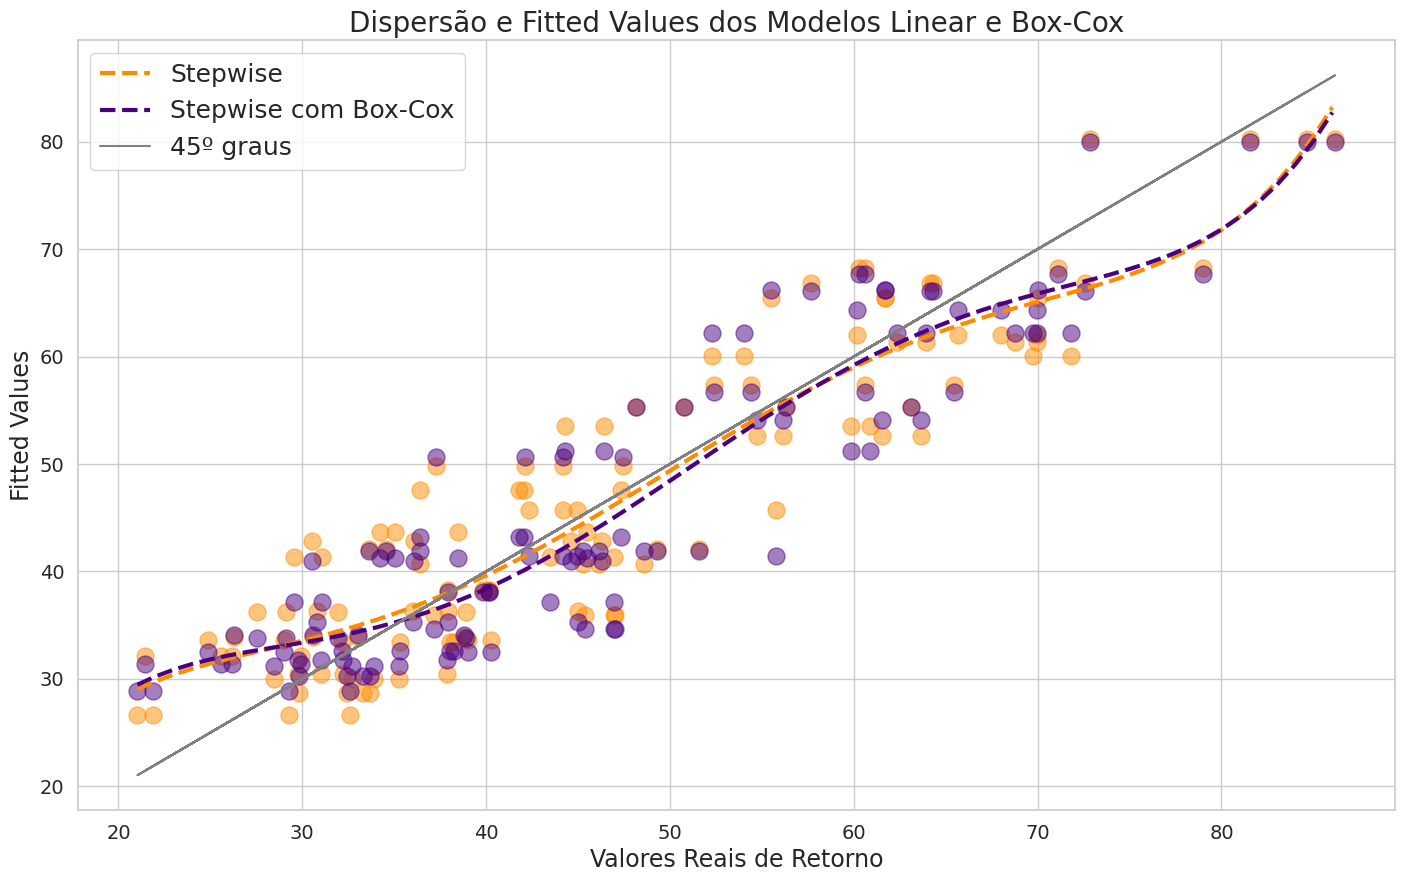

In [87]:
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

xdata = df_empresas['retorno']
ydata_linear = df_empresas['yhat_step_empresas']
ydata_bc = df_empresas['yhat_step_empresas_bc']

plt.figure(figsize=(17,10))

popt, _ = curve_fit(objective, xdata, ydata_linear)
a, b, c, d, e, f = popt
x_line = np.arange(min(xdata), max(xdata), 1)
y_line = objective(x_line, a, b, c, d, e, f)
plt.plot(x_line, y_line, '--', color='darkorange', linewidth=3)

popt, _ = curve_fit(objective, xdata, ydata_bc)
a, b, c, d, e, f = popt
x_line = np.arange(min(xdata), max(xdata), 1)
y_line = objective(x_line, a, b, c, d, e, f)
plt.plot(x_line, y_line, '--', color='indigo', linewidth=3)

plt.plot(xdata,xdata, color='gray', linestyle='-')
plt.scatter(xdata,ydata_linear, alpha=0.5, s=150, color='darkorange')
plt.scatter(xdata,ydata_bc, alpha=0.5, s=150, color='indigo')
plt.title('Dispersão e Fitted Values dos Modelos Linear e Box-Cox',
          fontsize=20)
plt.xlabel('Valores Reais de Retorno', fontsize=17)
plt.ylabel('Fitted Values', fontsize=17)
plt.legend(['Stepwise','Stepwise com Box-Cox','45º graus'], fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()